## **Capstone MDS - Preprocesamiento**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [1]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,  Lasso, LassoCV, lasso_path
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from matplotlib.ticker import EngFormatter

In [2]:
# función regresión lineal
def regresion_lineal(X_train, X_test, y_train, y_test):
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred_test = lm.predict(X_test)
    print('R2_test: ', r2_score(y_test, y_pred_test))
    print('MSE_test: ', mean_squared_error(y_test, y_pred_test))
    print('RMSE_test: ', np.sqrt(mean_squared_error(y_test, y_pred_test)))

    y_pred_train = lm.predict(X_train)
    print('R2_train: ', r2_score(y_train, y_pred_train))
    print('MSE_train: ', mean_squared_error(y_train, y_pred_train))
    print('RMSE_train: ', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    
    return lm

In [3]:
# función summary de regresión lineal
def summary_regresion_lineal(X_train, y_train):
    
    X_train = sm.add_constant(X_train)
    lm = sm.OLS(y_train, X_train).fit()
    print(lm.summary())
    
    return lm

In [4]:
def plot_coeficientes(modelo):
    coef = modelo.params
    
    # Obtener los nombres de las variables directamente desde el modelo
    variables = modelo.model.exog_names  
    conf_int = modelo.conf_int()
    
    # Determinar si conf_int es un DataFrame o un ndarray y actuar en consecuencia
    if isinstance(conf_int, np.ndarray):
        lower_bounds = conf_int[:, 0]
        upper_bounds = conf_int[:, 1]
    else:  # Si es un DataFrame
        lower_bounds = conf_int[0].values
        upper_bounds = conf_int[1].values

    err = (upper_bounds - lower_bounds) / 2

    plt.figure(figsize=(10, 5))
    sns.barplot(x=variables, y=coef, yerr=err)
    plt.xticks(rotation=45)
    plt.ylabel('Valor del Coeficiente')
    plt.title('Coeficientes del Modelo con Intervalo de Confianza del 95%')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


## **_1. Lectura (carga) de los Datos_**

In [5]:
# importamos archivo
df = pd.read_csv('df_final_pay.csv')

In [6]:
# miramos el dataframe
df.head()

,year_2023,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,CAT 797-F_des,KOM-CHQ_des,KOM.960E5_des,Kom.930E-4_des,Kom.930E-4SE_des,Kom.930EN_des,Kom.930ER_des,Kom.930ER-MT_des,Kom.980E5_des,Komatsu AHS_des
0,False,False,False,False,False,False,False,False,False,False,...,-2.945179,-0.696268,2.478283,0.189826,0.797269,1.971934,0.669895,-0.663137,-2.700349,-0.326143
1,False,False,False,False,False,False,False,False,False,False,...,-2.945179,-0.696268,2.478283,0.189826,0.842588,1.971934,0.669895,-0.663137,-2.700349,-0.326143
2,False,False,False,False,False,False,False,False,False,False,...,-2.945179,-0.696268,2.478283,0.189826,0.751949,1.971934,0.669895,-0.663137,-2.700349,-0.326143
3,False,False,False,False,False,False,False,False,False,False,...,-2.945179,-0.696268,2.478283,-1.638278,0.842588,1.971934,0.669895,-0.663137,-2.700349,-0.326143
4,False,False,False,False,False,False,False,False,False,False,...,-2.945179,-0.696268,2.478283,0.189826,0.797269,1.971934,0.669895,-0.663137,-2.700349,-0.326143


In [7]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1327 entries, 0 to 1326
Data columns (total 84 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year_2023             1327 non-null   bool   
 1   month_2               1327 non-null   bool   
 2   month_3               1327 non-null   bool   
 3   month_4               1327 non-null   bool   
 4   month_5               1327 non-null   bool   
 5   month_6               1327 non-null   bool   
 6   month_7               1327 non-null   bool   
 7   month_8               1327 non-null   bool   
 8   month_9               1327 non-null   bool   
 9   month_10              1327 non-null   bool   
 10  month_11              1327 non-null   bool   
 11  month_12              1327 non-null   bool   
 12  day_2                 1327 non-null   bool   
 13  day_3                 1327 non-null   bool   
 14  day_4                 1327 non-null   bool   
 15  day_5                

## **_2 Preparación del DataFrame_**

In [8]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [9]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['year_2023', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31', 'shift_B', 'crew_E2', 'crew_E3', 'crew_E4', 'distance',
       'distance_down', 'distance_down_level', 'distance_up',
       'distance_up_level', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'pay_original', 'total_des',
       'efectivo_des', 'mantencion_des', 'mecanica_des', 'electrica_des',
       'mant_excl_des', 'mec_excl_des', 'elec_excl_des', 'som_excl_des',
       'demora_des', 'r_prog_des', 'r_noprg_des', 'waiting_des', 'queued_des',
       'material_tonn

## **_3 Regresión Lineal Inicial_**

In [10]:
# definimos el tamaño del set de test
test_size = 0.25

In [11]:
# separamos los datos en X e y
X = df.drop('pay_original', axis=1)
y = df['pay_original']

# dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 

In [12]:
# aplicamos la función de regresión lineal
lm = regresion_lineal(X_train, X_test, y_train, y_test)

R2_test:  0.6357610858065624
MSE_test:  140857128.38892457
RMSE_test:  11868.324582219875
R2_train:  0.6702666873816296
MSE_train:  126953984.36199068
RMSE_train:  11267.38587082162


In [13]:
# sumario del modelo
ro=summary_regresion_lineal(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:           pay_original   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     22.64
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          2.29e-168
Time:                        14:49:24   Log-Likelihood:                -10694.
No. Observations:                 995   AIC:                         2.155e+04
Df Residuals:                     912   BIC:                         2.196e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.512e+05 

## _4 Optimización del Modelo (I)_ 

### _4.1 Selección de Variables_

#### _4.1.1 Utilizando Lasso_

In [14]:
# buscamos alpha optimo con LassoCV
alpha_values = np.linspace(0.01, 300, 30000)

# Crea un objeto LassoCV
lasso_cv = LassoCV(alphas=alpha_values, cv=5)

# Ajusta el modelo a los datos de entrenamiento
lasso_cv.fit(X_train, y_train)

# Valor óptimo de alpha
best_alpha = lasso_cv.alpha_

# Evalúa el modelo en el conjunto de prueba
score = lasso_cv.score(X_test, y_test)

print(f"Mejor valor de alpha: {best_alpha}")
print(f"Puntuación en el conjunto de prueba: {score}")

/home/evans/miniconda3/envs/tfgpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32057725.093582153, tolerance: 31144757.070262723
  model = cd_fast.enet_coordinate_descent_gram(
/home/evans/miniconda3/envs/tfgpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31634642.234161377, tolerance: 31144757.070262723
  model = cd_fast.enet_coordinate_descent_gram(
/home/evans/miniconda3/envs/tfgpu/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31275757.699188232, tolerance: 31144757.070262723
  model = cd_fast.enet_coordinate_descent_gram(
/home/evans/miniconda3/envs/

Mejor valor de alpha: 106.24000000000001
Puntuación en el conjunto de prueba: 0.6546429554635294


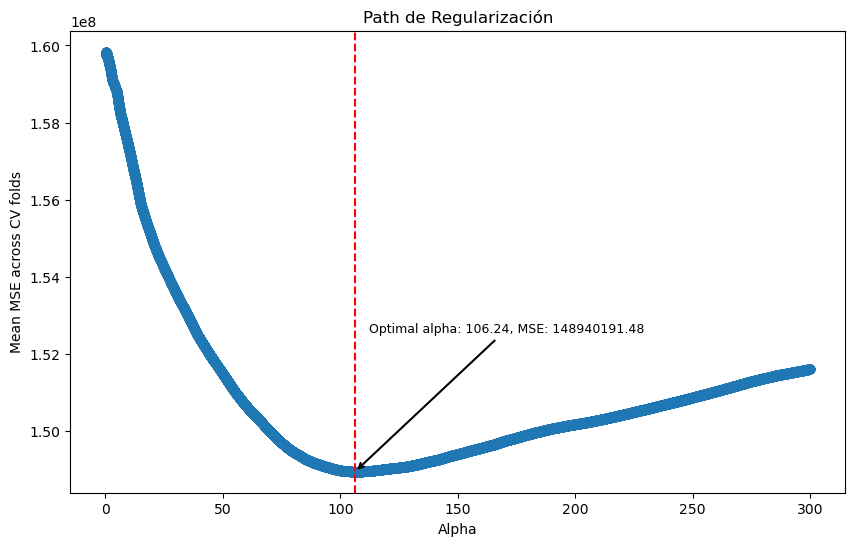

In [15]:
# Graficar MSE vs. Alpha
plt.figure(figsize=(10,6))
plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE across CV folds')
plt.title('Path de Regularización')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--')

# Anotar el valor óptimo de alpha en el gráfico
plt.annotate(f'Optimal alpha: {lasso_cv.alpha_:.2f}, MSE: {np.min(np.mean(lasso_cv.mse_path_, axis=1)):.2f}',
             xy=(lasso_cv.alpha_, np.min(np.mean(lasso_cv.mse_path_, axis=1))),
             xycoords='data', xytext=(10,100), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", lw=1.5),
             fontsize=9)

plt.show()

In [16]:
# Aplicar Lasso para la selección de características
lasso = Lasso(alpha=lasso_cv.alpha_)  
lasso.fit(X_train, y_train)

# Seleccionar las características que tienen coeficientes no nulos
selected_features = X_train.columns[lasso.coef_ != 0]

print("Características seleccionadas:")
print(selected_features)


Características seleccionadas:
Index(['year_2023', 'month_3', 'month_7', 'month_9', 'month_11', 'day_2',
       'day_23', 'day_30', 'shift_B', 'crew_E2', 'crew_E4', 'distance',
       'distance_down_level', 'distance_up_level', 'lift_down', 'travel_time',
       'total_des', 'efectivo_des', 'mantencion_des', 'mecanica_des',
       'electrica_des', 'mant_excl_des', 'mec_excl_des', 'elec_excl_des',
       'som_excl_des', 'demora_des', 'r_prog_des', 'waiting_des', 'queued_des',
       'payload_des', 'expected_time_des', 'CAT 797-F_des', 'Kom.930E-4_des',
       'Kom.930E-4SE_des', 'Kom.980E5_des'],
      dtype='object')


In [17]:
len(selected_features)

35

> Volvemos ajustar el modelo con las variables seleccionadas

In [18]:
# separamos los datos en train y test
X_lasso= df[selected_features]
y_lasso = df['pay_original']

# dividimos los datos en train y test
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=test_size, random_state=42)

In [19]:
# aplicamos la función de regresión lineal
lm_lasso = regresion_lineal(X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso)

R2_test:  0.6422747512253757
MSE_test:  138338187.74192655
RMSE_test:  11761.725542705311
R2_train:  0.6552214768197877
MSE_train:  132746694.26813723
RMSE_train:  11521.575164366079


In [20]:
# sumario del modelo
ls = summary_regresion_lineal(X_train_lasso, y_train_lasso)

                            OLS Regression Results                            
Dep. Variable:           pay_original   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     52.07
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          4.55e-195
Time:                        14:49:41   Log-Likelihood:                -10717.
No. Observations:                 995   AIC:                         2.151e+04
Df Residuals:                     959   BIC:                         2.168e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.444e+05   1

In [21]:
test_predictions = lm_lasso.predict(X_test_lasso)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test_lasso}).sort_index()
test_results

,Test Predictions,Actuals
10,161919.944971,134593.450048
23,166395.207783,175253.907957
29,168054.660405,158648.649210
31,159394.499120,154207.599007
32,173128.260399,161414.870969
...,...,...
1310,138964.634160,126861.045774
1311,131022.205495,115694.820036
1312,130620.185705,103283.638073
1313,125304.601479,103344.433146


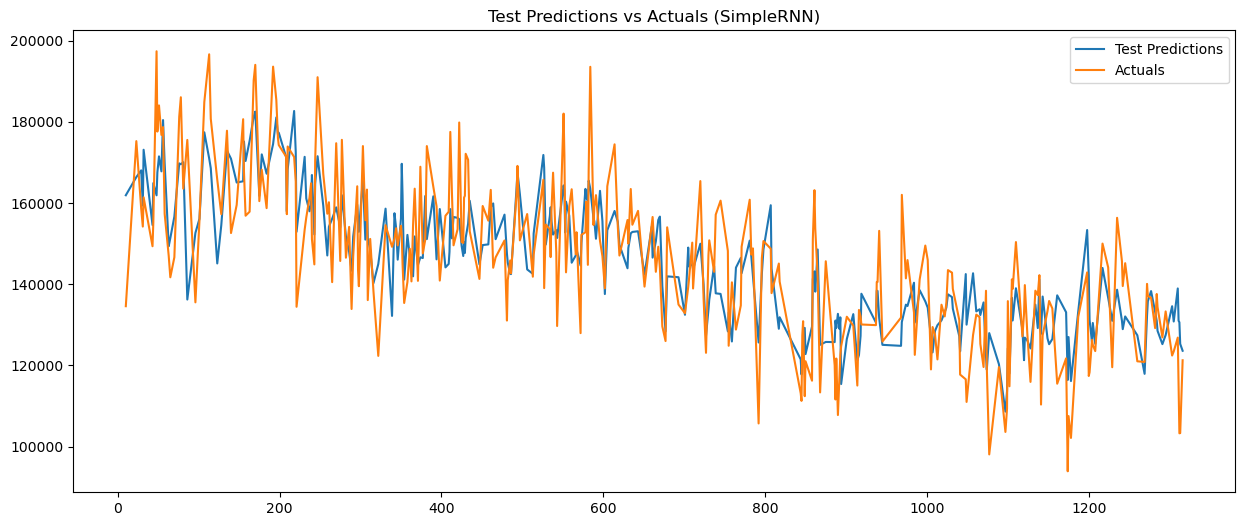

In [22]:
plt.figure(figsize=(15,6))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

plt.title('Test Predictions vs Actuals (SimpleRNN)')
plt.legend(['Test Predictions', 'Actuals'])
plt.show()

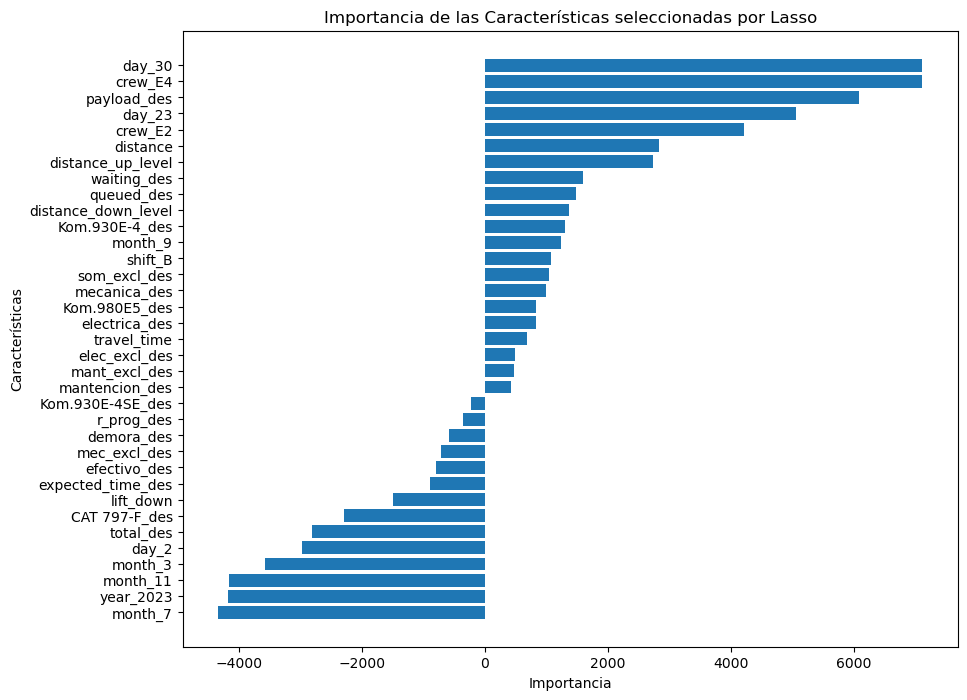

In [23]:
# Obtener los coeficientes del modelo Lasso
lasso_coef = lm_lasso.coef_

# Crear un DataFrame con las características y sus coeficientes
feature_importance = pd.DataFrame({'features': X_train_lasso.columns, 'importance': lasso_coef})

# Filtrar para mantener solo las características con coeficientes no nulos
feature_importance = feature_importance[feature_importance['importance'] != 0]

# Ordenar las características por importancia
feature_importance = feature_importance.sort_values(by='importance', ascending=True)

# Crear un gráfico de barras horizontales
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['features'], feature_importance['importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características seleccionadas por Lasso')
plt.show()

### _4.2 Residuos_

#### _4.2.1 En Conjunto Entrenamiento_

> Nos quedamos con la selección de variables obtenidas en Lasso.

In [21]:
# separamos los datos en X e y para las variables seleccionadas
X = df[X_train_lasso.columns]
y = df['pay_original']

# separamos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [22]:
# iniciamos el modelo
lr = LinearRegression()

# ajustamos el modelo
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
# predicción conjunto entrenamiento y residuales
y_pred_train = lr.predict(X_train)
residual_train = y_train - y_pred_train

# ordenamos los datos
residual_train_order = residual_train.sort_index()
X_train_order = X_train.sort_index()

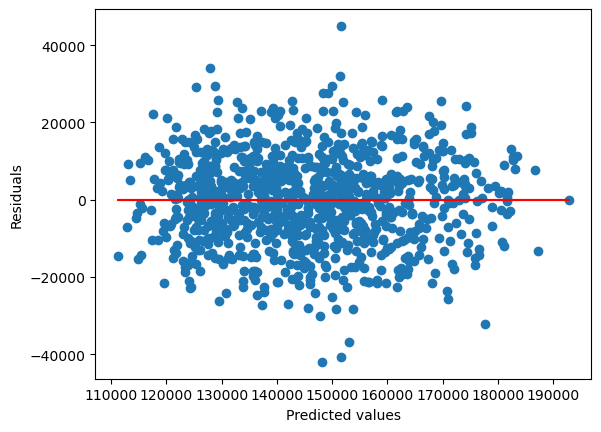

In [24]:
# graficamos los residuales
plt.scatter(y_pred_train, residual_train)
plt.ylabel('Residuals')
plt.xlabel('Predicted values')

# graficamos la linea de tendencia
coefficients = np.polyfit(y_pred_train, residual_train, 1)
line = np.polyval(coefficients, y_pred_train)
plt.plot(y_pred_train, line, color='red', label='Tendencia cuadrática')

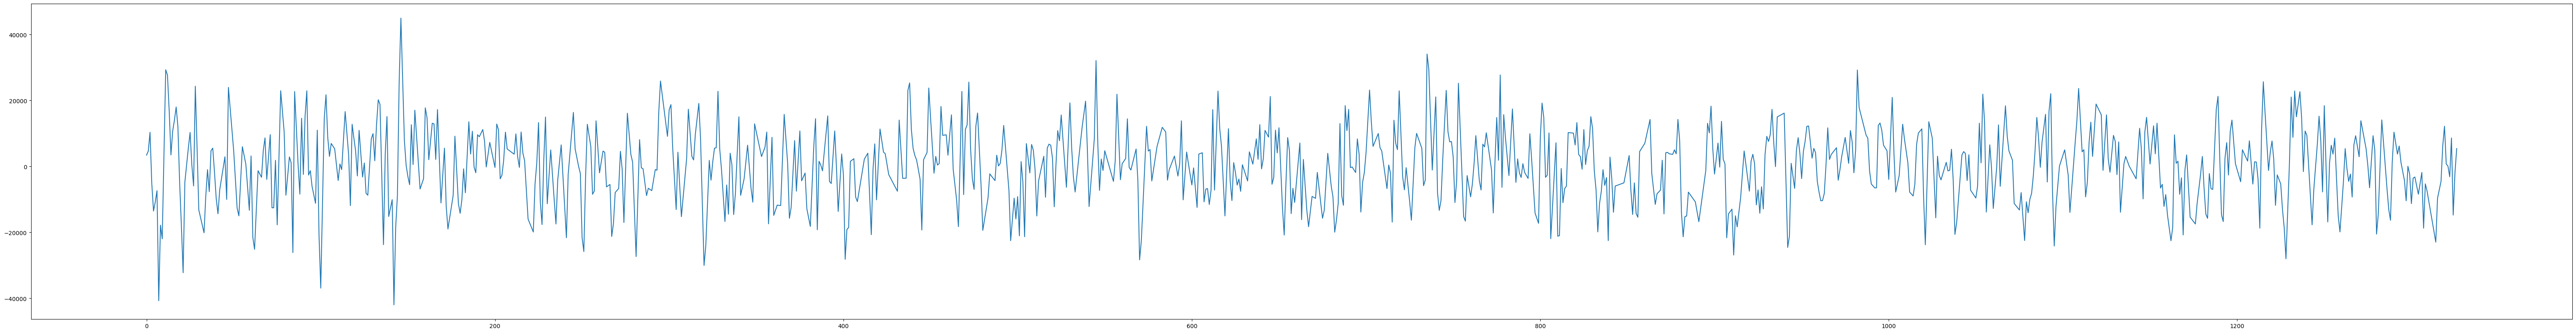

In [25]:
# grafaica de los residuos vs el tiempo 
plt.figure(figsize=(80,10))
plt.plot(X_train_order.index, residual_train_order)

plt.show()

#### _4.2.2 En Conjunto Test_

In [26]:
# predicción conjunto entrenamiento y residuales
y_pred_test = lr.predict(X_test)
residual_test = y_test - y_pred_test

# ordenamos los datos
residual_test_order = residual_test.sort_index()
X_test_order = X_test.sort_index()

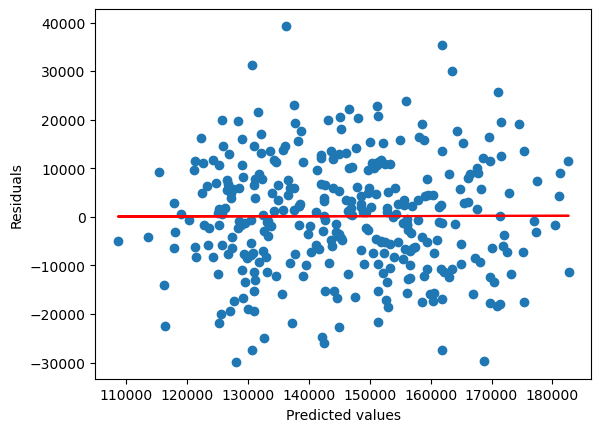

In [27]:
# gráfica de los residuos
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals)
plt.ylabel('Residuals')
plt.xlabel('Predicted values')

# graficamos la linea de tendencia
coefficients = np.polyfit(y_pred_test, residuals, 1)
line = np.polyval(coefficients, y_pred_test)
plt.plot(y_pred_test, line, color='red', label='Tendencia cuadrática')


In [28]:
# ordenamos los residuos por indice de menor a mayor
residual_order = residuals.sort_index()
X_order = X_test.sort_index()

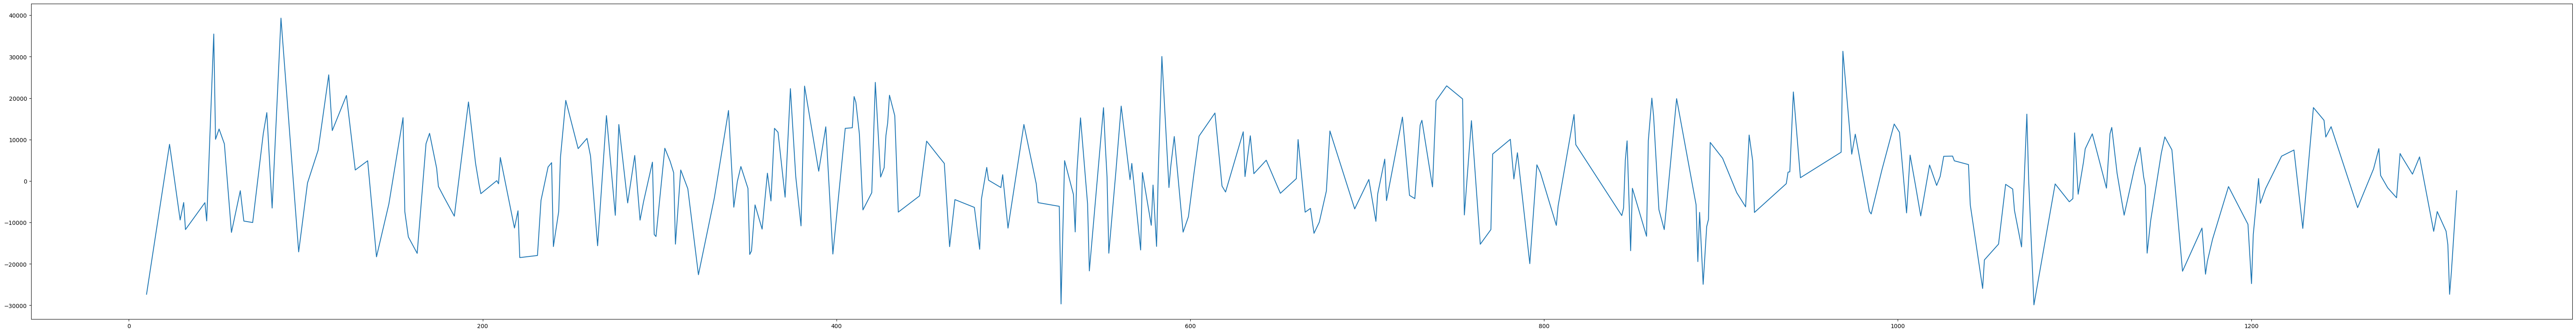

In [29]:
# grafaica de los residuos vs el tiempo 
plt.figure(figsize=(80,10))
plt.plot(X_order.index, residual_order)

### _4.3 Heteroscedasticidad - Logaritmo Variable Objetivo_

> Quitamos un 'material_tonnage' que es 0 (revisar después del despeje de los outliers)

In [30]:
# separamos los datos en train y test
X = df[X_train_lasso.columns]
y = np.log(df['pay_original'])

# separamos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [31]:
# aplicamos la función de regresión lineal
lm_log = regresion_lineal(X_train, X_test, y_train, y_test)

R2_test:  0.6411638702256388
MSE_test:  0.006729246418475395
RMSE_test:  0.08203198411885083
R2_train:  0.6448783897161448
MSE_train:  0.006548746446226386
RMSE_train:  0.0809243254295418


In [32]:
# calculamos el valor inverso de la transformación logaritmica para RMSE y MSE
RMSE = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(lm_log.predict(X_test))))
MSE = mean_squared_error(np.exp(y_test), np.exp(lm_log.predict(X_test)))
RMSE, MSE

(11760.193379903321, 138302148.33272192)

In [33]:
# sumario del modelo
summary_regresion_lineal(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:           pay_original   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     49.76
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          5.01e-189
Time:                        14:26:26   Log-Likelihood:                 1089.8
No. Observations:                 995   AIC:                            -2108.
Df Residuals:                     959   BIC:                            -1931.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.8719    

## _5 Optimización del Modelo (II)_ 

In [34]:
# generamos un nuevo dataframe con las variables seleccionadas
df_int = pd.concat([df[X_train_lasso.columns],df['pay_original']], axis=1).copy()
df_int

,year_2023,month_3,month_7,month_9,month_11,day_2,day_23,day_30,shift_B,crew_E2,...,r_prog_des,waiting_des,queued_des,payload_des,expected_time_des,CAT 797-F_des,Kom.930E-4_des,Kom.930E-4SE_des,Kom.980E5_des,pay_original
0,0,0,0,0,0,1,0,0,0,0,...,1.127526,1.192359,1.600309,2.568186,-0.595768,-2.945179,0.189826,0.797269,-2.700349,182896.714123
1,0,0,0,0,0,1,0,0,1,1,...,2.156343,1.606061,0.835494,2.282092,-0.683754,-2.945179,0.189826,0.842588,-2.700349,177821.821993
2,0,0,0,0,0,0,0,0,0,0,...,1.267743,0.568951,-0.947892,1.900887,-0.663256,-2.945179,0.189826,0.751949,-2.700349,184522.752091
3,0,0,0,0,0,0,0,0,1,1,...,2.104027,1.928874,-1.518449,1.643401,-0.470938,-2.945179,-1.638278,0.842588,-2.700349,169636.141007
4,0,0,0,0,0,0,0,0,0,0,...,1.113427,0.916988,-1.513988,1.983387,-0.424168,-2.945179,0.189826,0.797269,-2.700349,160945.398989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,1,0,0,0,0,0,0,0,1,0,...,0.309436,-0.844075,0.533746,-0.929928,1.750565,0.408459,0.189826,1.386422,0.378153,128144.590977
1323,1,0,0,0,0,0,0,1,0,0,...,0.202504,-1.757551,-0.872632,-0.804033,1.327212,0.380512,0.189826,1.386422,0.378153,137431.611084
1324,1,0,0,0,0,0,0,1,1,0,...,0.081787,-0.757457,1.313905,-0.877079,1.733387,0.408459,0.189826,1.386422,0.378153,120640.104073
1325,1,0,0,0,0,0,0,0,0,0,...,0.289517,-0.917039,-0.435125,-0.405882,0.770693,0.380512,0.189826,1.386422,0.378153,123821.245016


### _5.1 Interacción 'payload_des' por 'distance'_

In [35]:
# creamos la nueva variable
df_int['pay_des_distance'] = df_int['payload_des'] * df_int['distance']
df_int['pay_des_distance']

0      -0.146207
1      -1.223146
2      -0.321743
3       0.454981
4      -0.359038
          ...   
1322   -1.419809
1323   -0.172764
1324   -0.974458
1325   -0.019637
1326   -0.819947
Name: pay_des_distance, Length: 1327, dtype: float64

In [36]:
# separamos los datos en X e y
X_int1 = df_int.drop('pay_original', axis=1)
y_int1 = df_int['pay_original']

# dividimos los datos en train y test
X_train_int1, X_test_int1, y_train_int1, y_test_int1 = train_test_split(X_int1, y_int1, test_size=test_size, random_state=42)

In [37]:
# aplicamos la función de regresión lineal
lm_int1 = regresion_lineal(X_train_int1, X_test_int1, y_train_int1, y_test_int1)

R2_test:  0.6471752306637226
MSE_test:  136443092.42257267
RMSE_test:  11680.885772173815
R2_train:  0.6588348195481022
MSE_train:  131355484.34584501
RMSE_train:  11461.042027051686


In [38]:
# sumario del modelo
summary_regresion_lineal(X_train_int1, y_train_int1)

                            OLS Regression Results                            
Dep. Variable:           pay_original   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     51.39
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          2.34e-196
Time:                        14:26:27   Log-Likelihood:                -10712.
No. Observations:                 995   AIC:                         2.150e+04
Df Residuals:                     958   BIC:                         2.168e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.449e+05   1

### _5.2 Interacción 'payload_des' por 'expected_time_des'_

In [39]:
# creamos la nueva variable
df_int['pay_des_exp_time_des'] = df_int['payload_des'] * df_int['expected_time_des']
df_int['pay_des_exp_time_des']

0      -1.530042
1      -1.560389
2      -1.260775
3      -0.773940
4      -0.841289
          ...   
1322   -1.627900
1323   -1.067122
1324   -1.520318
1325   -0.312810
1326   -2.199959
Name: pay_des_exp_time_des, Length: 1327, dtype: float64

In [40]:
# separamos los datos en X e y
X_int2 = df_int.drop('pay_original', axis=1)
y_int2 = df_int['pay_original']

# dividimos los datos en train y test
X_train_int2, X_test_int2, y_train_int2, y_test_int2 = train_test_split(X_int2, y_int2, test_size=test_size, random_state=42)

In [41]:
# aplicamos la función de regresión lineal
lm_int2 = regresion_lineal(X_train_int2, X_test_int2, y_train_int2, y_test_int2)

R2_test:  0.641964598912032
MSE_test:  138458128.6996837
RMSE_test:  11766.823220380415
R2_train:  0.6595728456466523
MSE_train:  131071329.39337738
RMSE_train:  11448.63875722251


In [42]:
# sumario del modelo
summary_regresion_lineal(X_train_int2, y_train_int2)

                            OLS Regression Results                            
Dep. Variable:           pay_original   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     50.11
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          6.11e-196
Time:                        14:26:27   Log-Likelihood:                -10711.
No. Observations:                 995   AIC:                         2.150e+04
Df Residuals:                     957   BIC:                         2.168e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.448e+05 

### _5.3 Interacción 'payload_des' por 'CAT 797-F_des'_

In [43]:
# creamos la nueva variable
df_int['pay_des_CAT_des'] = df_int['payload_des'] * df_int['CAT 797-F_des']
df_int['pay_des_CAT_des']

0      -7.563766
1      -6.721169
2      -5.598452
3      -4.840111
4      -5.841430
          ...   
1322   -0.379838
1323   -0.305944
1324   -0.358251
1325   -0.154443
1326   -0.478622
Name: pay_des_CAT_des, Length: 1327, dtype: float64

In [44]:
# separamos los datos en X e y
X_int3 = df_int.drop('pay_original', axis=1)
y_int3 = df_int['pay_original']

# dividimos los datos en train y test
X_train_int3, X_test_int3, y_train_int3, y_test_int3 = train_test_split(X_int3, y_int3, test_size=test_size, random_state=42)

In [45]:
# aplicamos la función de regresión lineal
lm_int3 = regresion_lineal(X_train_int3, X_test_int3, y_train_int3, y_test_int3)

R2_test:  0.6383417866971322
MSE_test:  139859129.26661405
RMSE_test:  11826.205192986212
R2_train:  0.6598861273546004
MSE_train:  130950709.60905556
RMSE_train:  11443.369678947523


In [46]:
# sumario del modelo
summary_regresion_lineal(X_train_int3, y_train_int3)

                            OLS Regression Results                            
Dep. Variable:           pay_original   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     48.81
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          2.83e-195
Time:                        14:26:27   Log-Likelihood:                -10710.
No. Observations:                 995   AIC:                         2.150e+04
Df Residuals:                     956   BIC:                         2.169e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.448e+05 

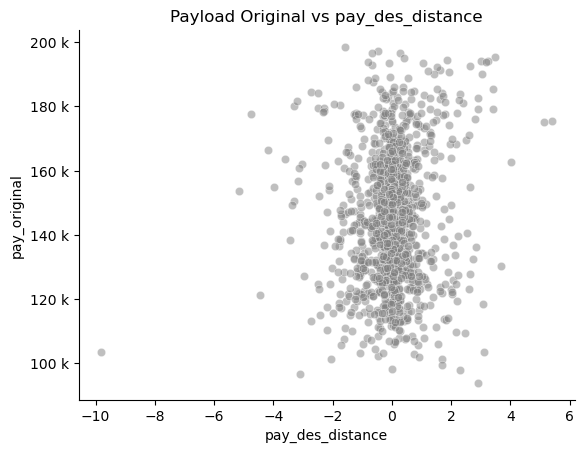

In [47]:
# graficamos 'payload_original' vs 'lift_down'
sns.scatterplot(x='pay_des_distance', y='pay_original', data=df_int, alpha=0.5, color='gray')

sns.despine()
plt.title('Payload Original vs pay_des_distance') 
plt.gca().yaxis.set_major_formatter(EngFormatter())
plt.show()